In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import vr2p
from vr2p import styles
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle
from multiday_suite2p.utils import create_mask_img
import numpy as np
import skimage
from vr2p.signal import df_over_f0
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar)
import figrid as fg
from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea
import matplotlib.patches as mpatches
import matplotlib.lines as lines
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, size=0, label=None, horizontal = True, style = 'dark', loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width / height of the bar, in data units.
        - label: label for bars; None to omit
        - horizontal: Whether the bar is horizontal (True) or vertical (False)
        - style: Whether the bar is dark ('dark') or bright (anything else)
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea
        import matplotlib.patches as mpatches
        bars = AuxTransformBox(transform)
        endpt = (size, 0) if horizontal else (0, size)
        art = mpatches.FancyArrowPatch((0, 0), endpt,
                                       arrowstyle = "-")
        bars.add_artist(art)

        packer = VPacker if horizontal else HPacker
        bars = packer(children=[bars, TextArea(label)],
                       align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)
class AnchoredDoubleScaleBar(AnchoredOffsetbox):
     def __init__(self, transform, x_size,x_label,y_size,y_label, **kwargs):
        x_label=f"{x_size} {x_label}"
        y_label=f"{y_size} {y_label}"
        x_line = lines.Line2D((0, -x_size), (0,0),color='black',marker='.',linewidth=1,markersize=0)
        y_line = lines.Line2D((0, 0), (0,y_size),color='black',marker='.',linewidth=1,markersize=0)
        bars = AuxTransformBox( transform)
        bars.add_artist(y_line)
        bars.add_artist(x_line)
        bars = VPacker(children = [
                            HPacker(children=[bars,TextArea(y_label)],align="center", pad=0, sep=2),  
                            TextArea(x_label)
                        ],align="left",sep=2)

        AnchoredOffsetbox.__init__(self, loc=4, pad=0.1, borderpad=0.1,                                   
                                   child=bars, prop=None, frameon=False)
    
def sort_windows_by_max_act(activity, win_size, frame_duration):
    act_list = []
    # go through all activity windows with sliding window
    for start_frame in np.arange(0,activity.shape[1],50):
        end_frame = start_frame + win_size
        if end_frame <= activity.shape[1]:
            c_act = activity[:,start_frame:end_frame]
            # get maximumactivity each cell.
            act_score= np.median(np.max(c_act,axis=1))
            act_list.append({'start_time':start_frame*frame_duration,'end_time':end_frame * frame_duration,'act_score':act_score})
    return pd.DataFrame(act_list).sort_values(by='act_score',ascending=False).reset_index(drop=True)

# Show all slices

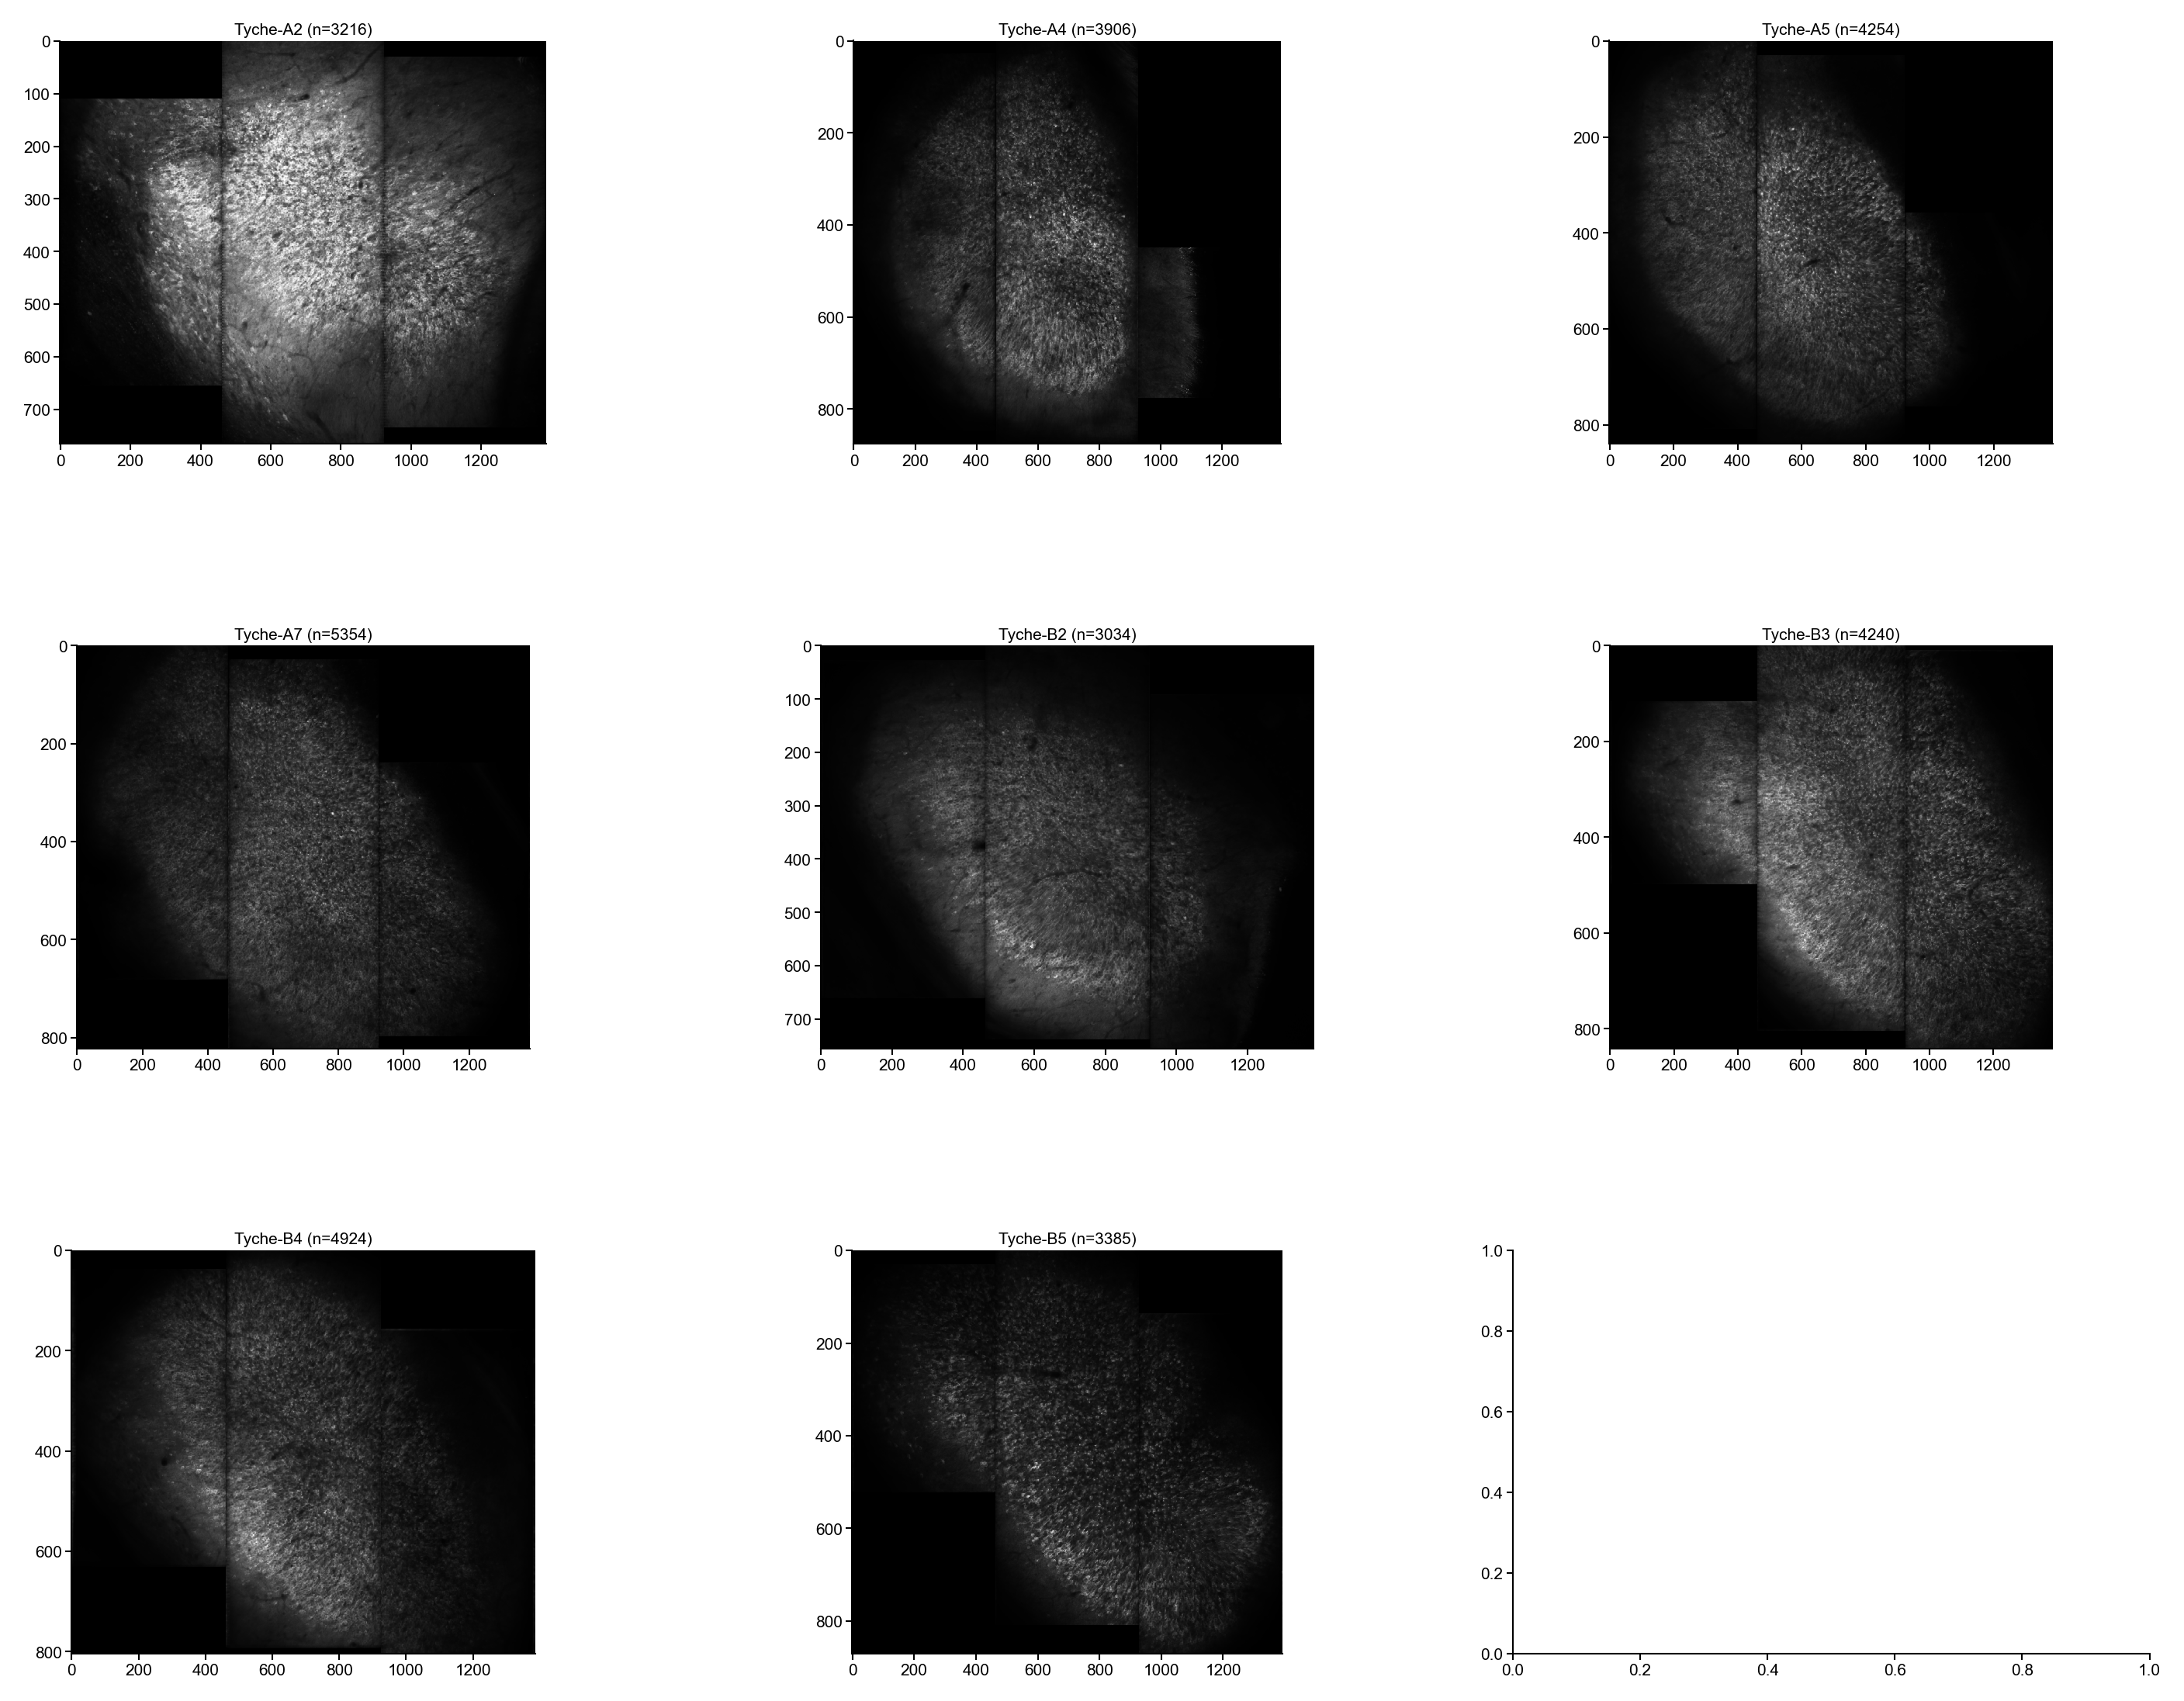

In [9]:
%matplotlib inline
plt.style.use(styles('publication-tight'))

animals = ['A2','A4','A5','A7','B2','B3','B4','B5']
fig, axs = plt.subplots(3,3,figsize=(12,9),dpi=300)
axs = axs.flatten()
plt.subplots_adjust(hspace = .5)
for i, animal in enumerate(animals):
    data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')

    # images to access.
    session_ind = 0
    img_type = 'mean_img'

    # get images.
    img = data.images.original[session_ind][img_type]

    # Plot images.
    axs[i].imshow(img,interpolation='none',cmap='gray',aspect=1.5) # correct non uniform aspect ratio.

    # formatting
    axs[i].set_title(f"Tyche-{animal} (n={data.cells.multi_session.registered.size})")

# 0. General settings.

In [10]:
# images to access.
session_ind = 0 
animal = 'A7' 
roi_type = 'single_session' # single_session or multi_session cell roi's

# 1. Overview image whole tissue

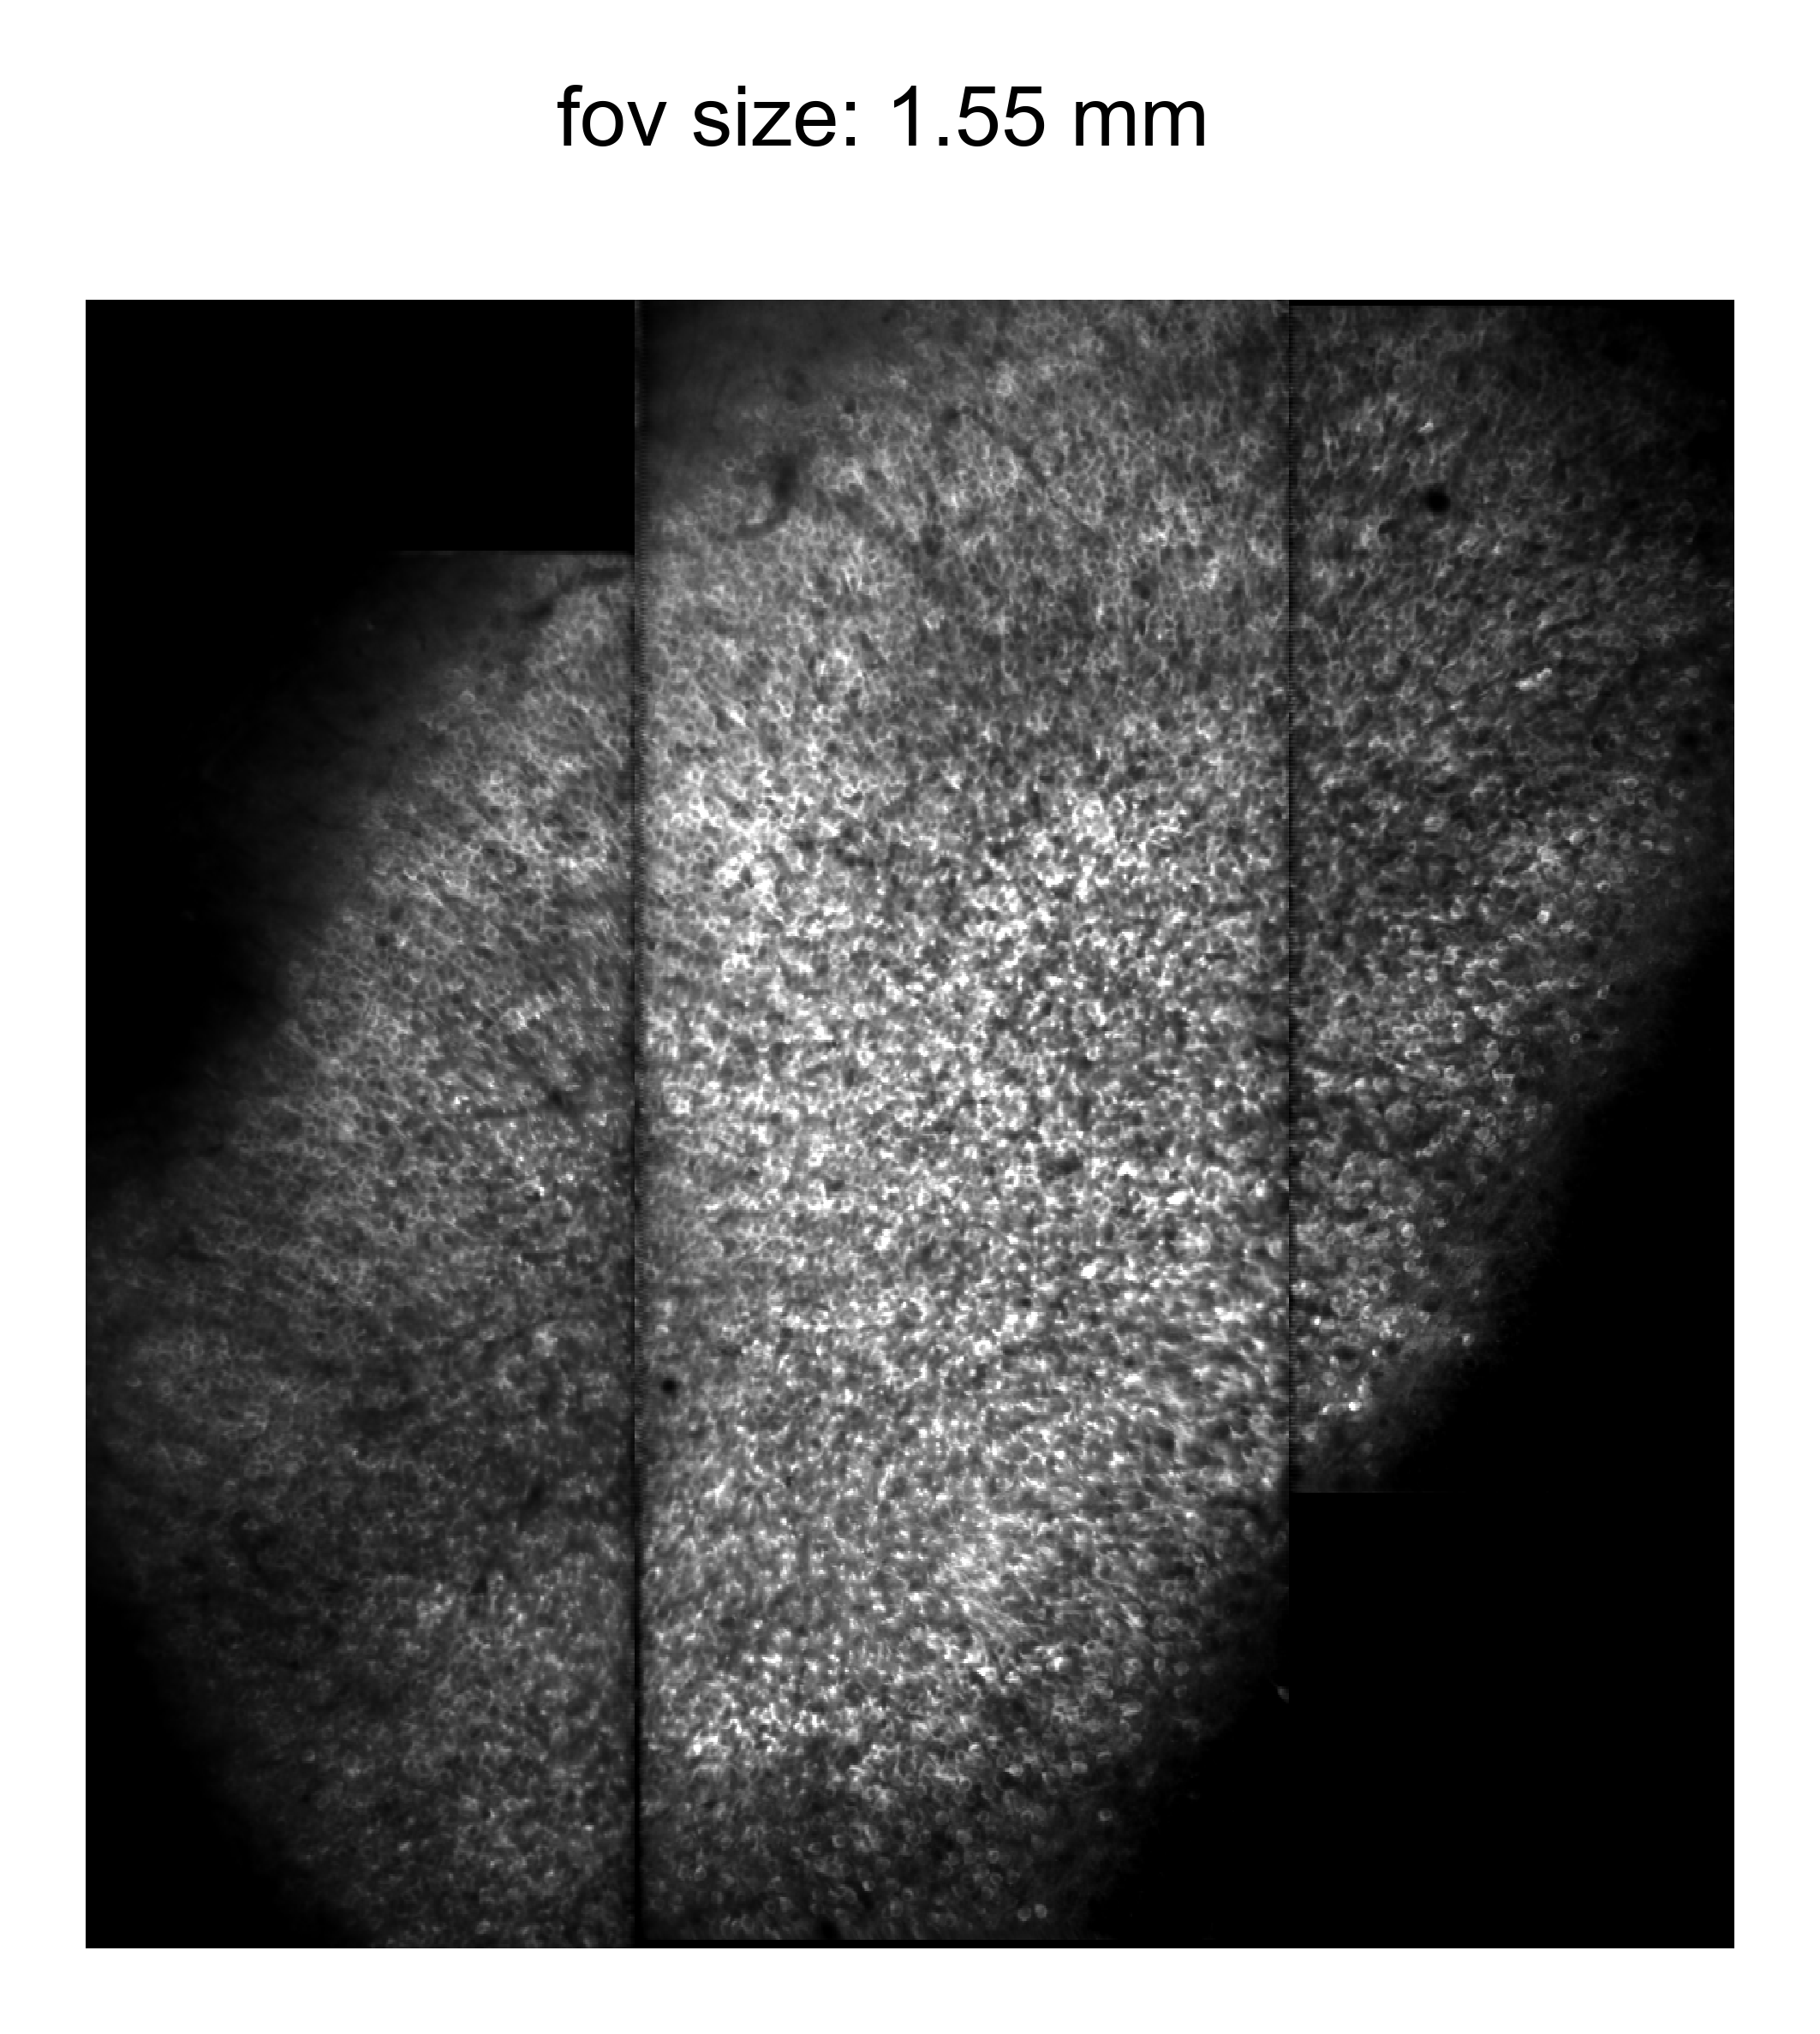

In [11]:
img_type = 'mean_img'
# FOV settings
disp_range = [100,1800]
pix_size = [1.333,2] #xy
fov_size_mm = 1.55
fov_origin_mm = [0.1,0.05] # left bottom origin.
show_axis=False
show_crop = False
# crop settings.
crop_size_mm = 0.125
crop_origin_mm = [0.7,1.25] #left bottom [1.0,0.8]
crop_line_width=0.5

# Grab data.
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')

#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=1000)
ax = fig.add_subplot(1, 1, 1)

ax.set_facecolor("black")
# get images.
img = data.images.original[session_ind][img_type]
fov_mm = [[fov_origin_mm[0],fov_origin_mm[0] + fov_size_mm],
          [fov_origin_mm[1],fov_origin_mm[1] + fov_size_mm]] # fov crop in x -y
ax.imshow(img, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none',cmap='gray', vmin=disp_range[0], vmax=disp_range[1]) # correct non uniform aspect ratio.
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])

# Add crop region.
if show_crop:
    ax.add_patch(Rectangle((crop_mm[0][0],crop_mm[1][0]),
                           crop_mm[0][1]-crop_mm[0][0], 
                           crop_mm[1][1]-crop_mm[1][0],
                          facecolor='none', edgecolor='white',linewidth=crop_line_width,))
fig.suptitle(f'fov size: {fov_size_mm} mm')
# format
if not show_axis:
    ax.tick_params(left = False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# 2. Whole FOV with masks.

7309


Text(0.5, 0.98, 'fov size: 1.55 mm')

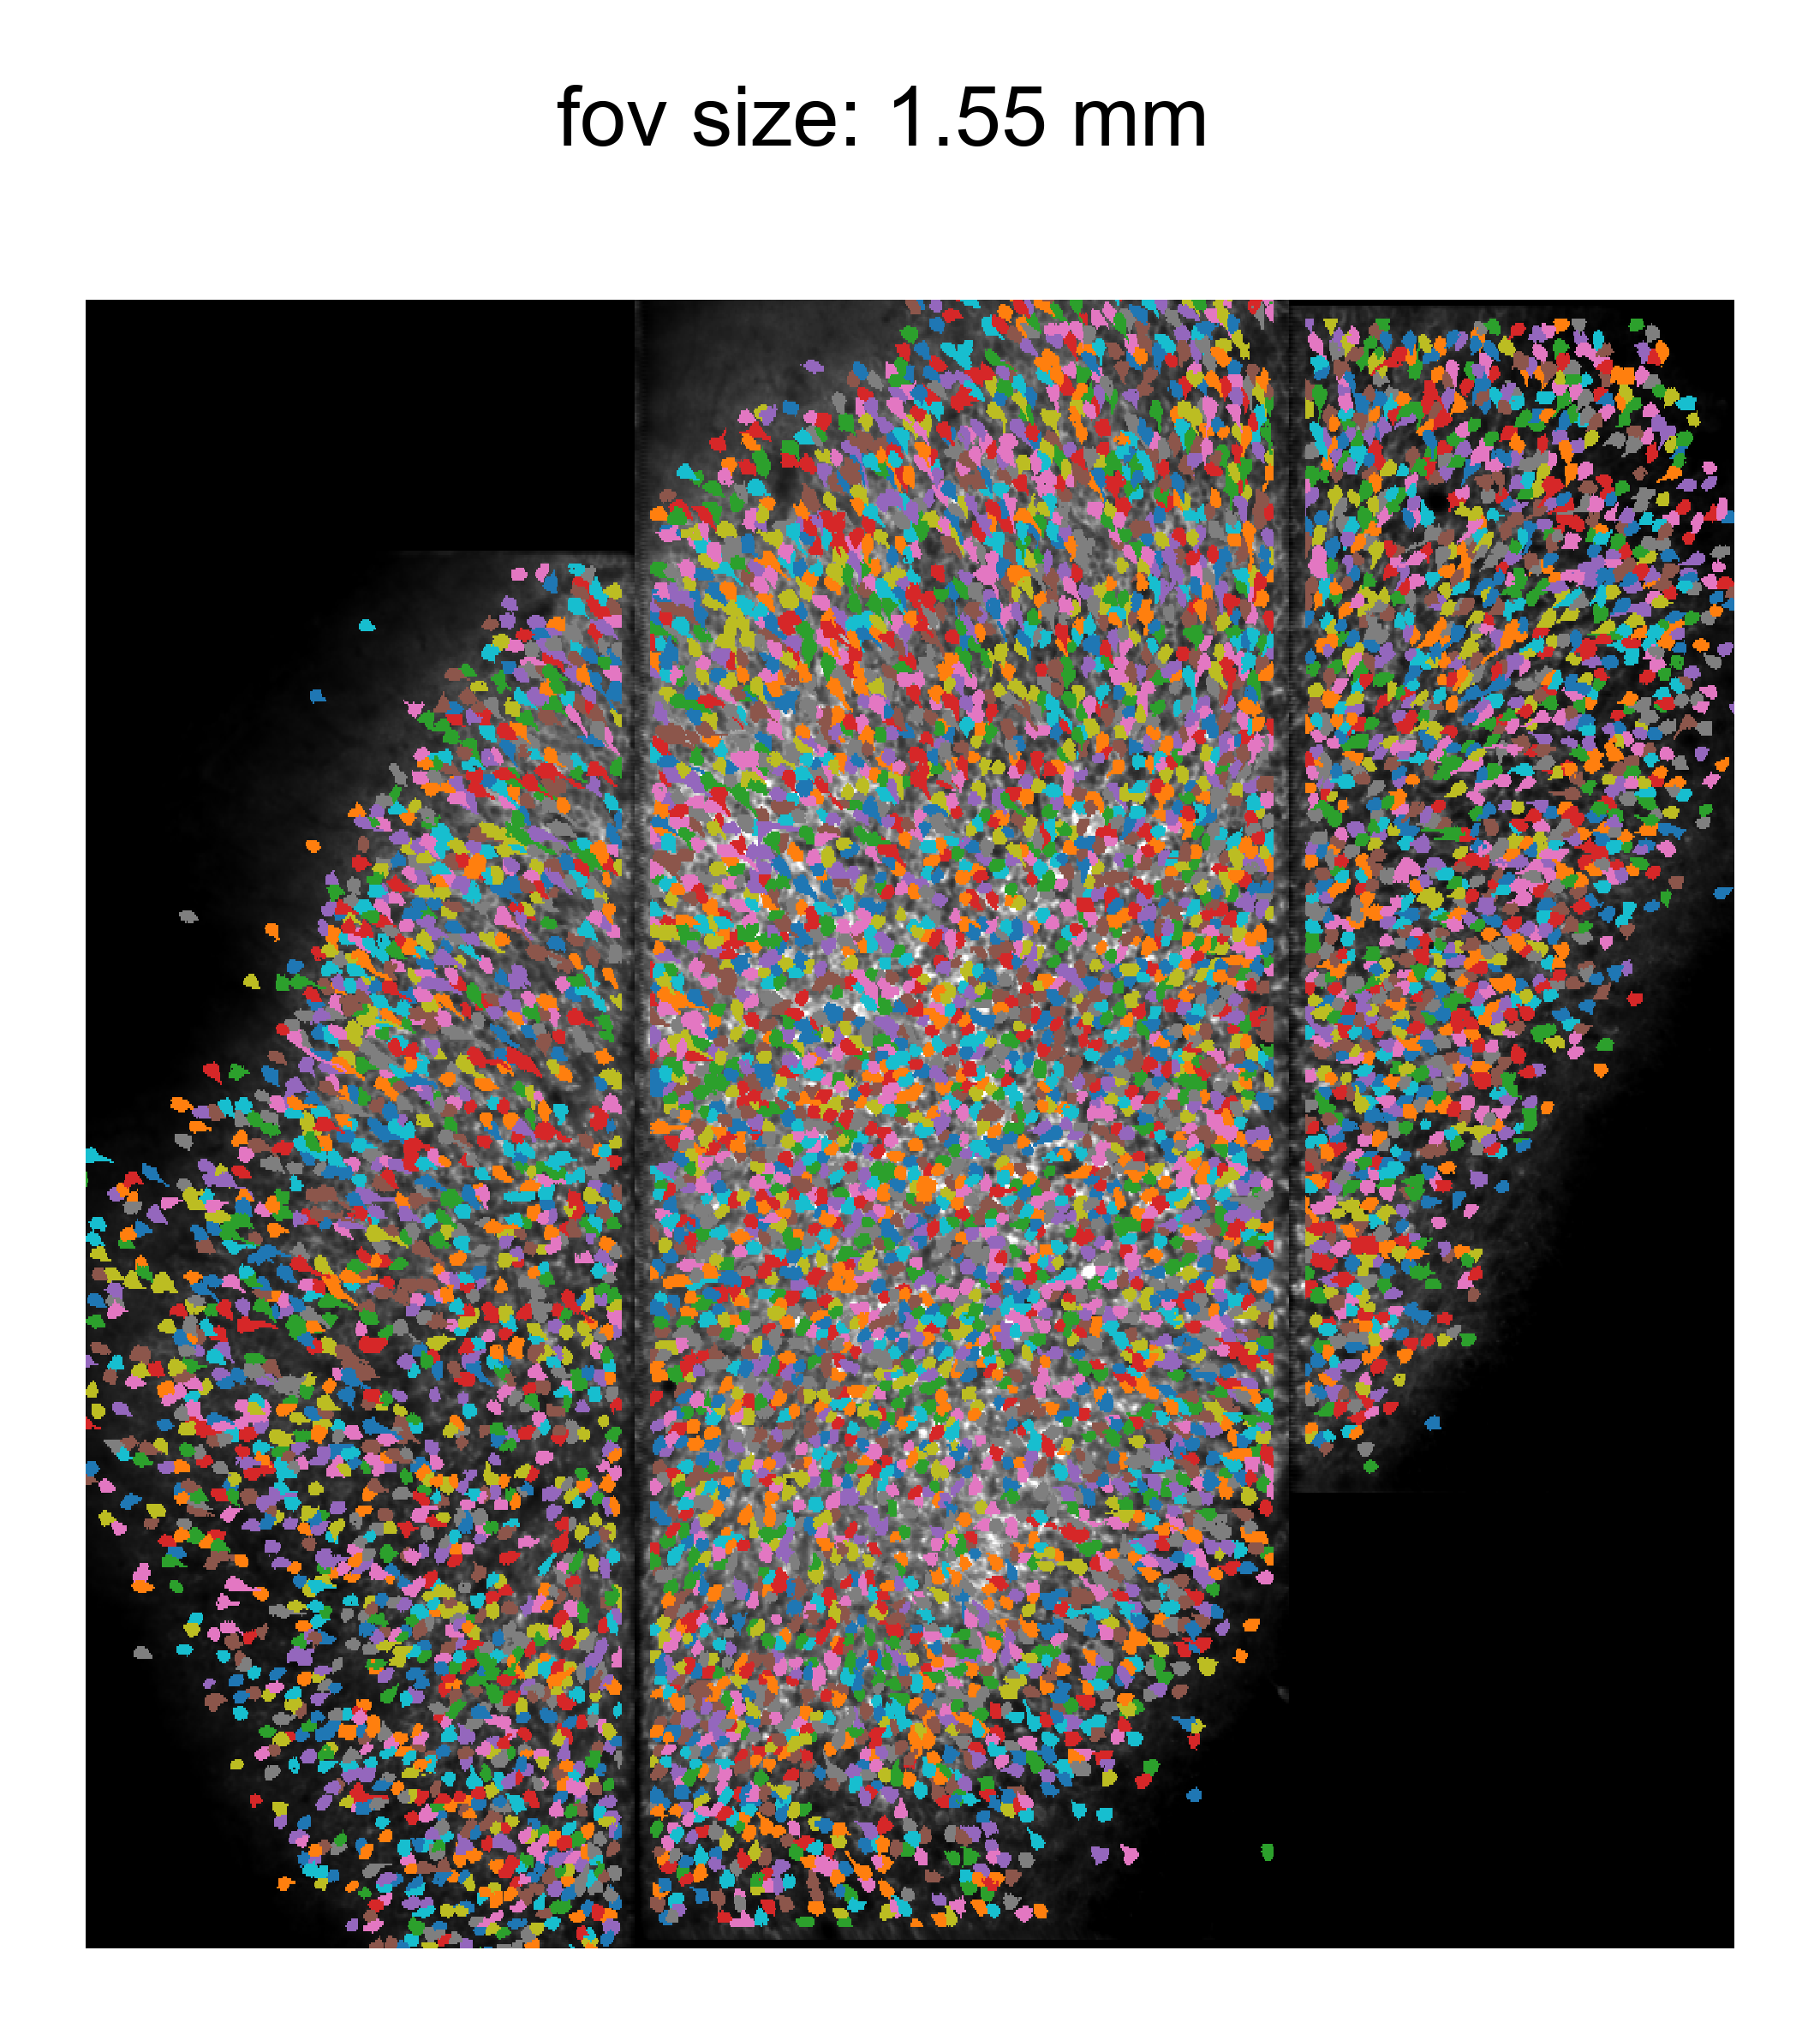

In [16]:
show_contours=False
color_seed_num = 2 # for randomizing colors.

#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=1000)
ax = fig.add_subplot(1, 1, 1)
#get image.
img = data.images.original[session_ind][img_type]
img_8bit = skimage.exposure.rescale_intensity(img,in_range=tuple(disp_range),out_range=(0,255)).astype(np.uint8)

# get image of cell masks.
roi_info = data.cells.multi_session.original[session_ind] if roi_type=='multi_session' else data.cells.single_session[session_ind]
if show_contours:
    cells_img = create_mask_img(roi_info, img.shape,contours=False)
else:
    cells_img = create_mask_img(roi_info, img.shape)
print(len(roi_info))

# create random colormap.
num_cells = cells_img.max()
np.random.seed(color_seed_num)
# fixed number of colors.
rand_cmap = np.array(sns.color_palette("tab10"))
rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]

# create roi masks.
mask_rgb = skimage.color.label2rgb(cells_img,img_8bit, colors=rand_cmap,alpha=1,bg_color=None) # something labeled as '1' will look at the first (zero index] color in the list. create mask sets first mask as 0 in the image (so effectively skipped)
cell_colors = np.vstack((np.zeros((rand_cmap.shape[1])),rand_cmap)) # because first one is (zero) is background

ax.imshow(mask_rgb, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none')
ax.axis('off')
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])
# Add crop region.
if show_crop:
    ax.add_patch(Rectangle((crop_mm[0][0],crop_mm[1][0]),
                           crop_mm[0][1]-crop_mm[0][0], 
                           crop_mm[1][1]-crop_mm[1][0],
                          facecolor='none', edgecolor='white',linewidth=crop_line_width,))
fig.suptitle(f'fov size: {fov_size_mm} mm')

# 3. Crop with countours.

Text(0.5, 0.98, 'fov size: 0.125 mm')

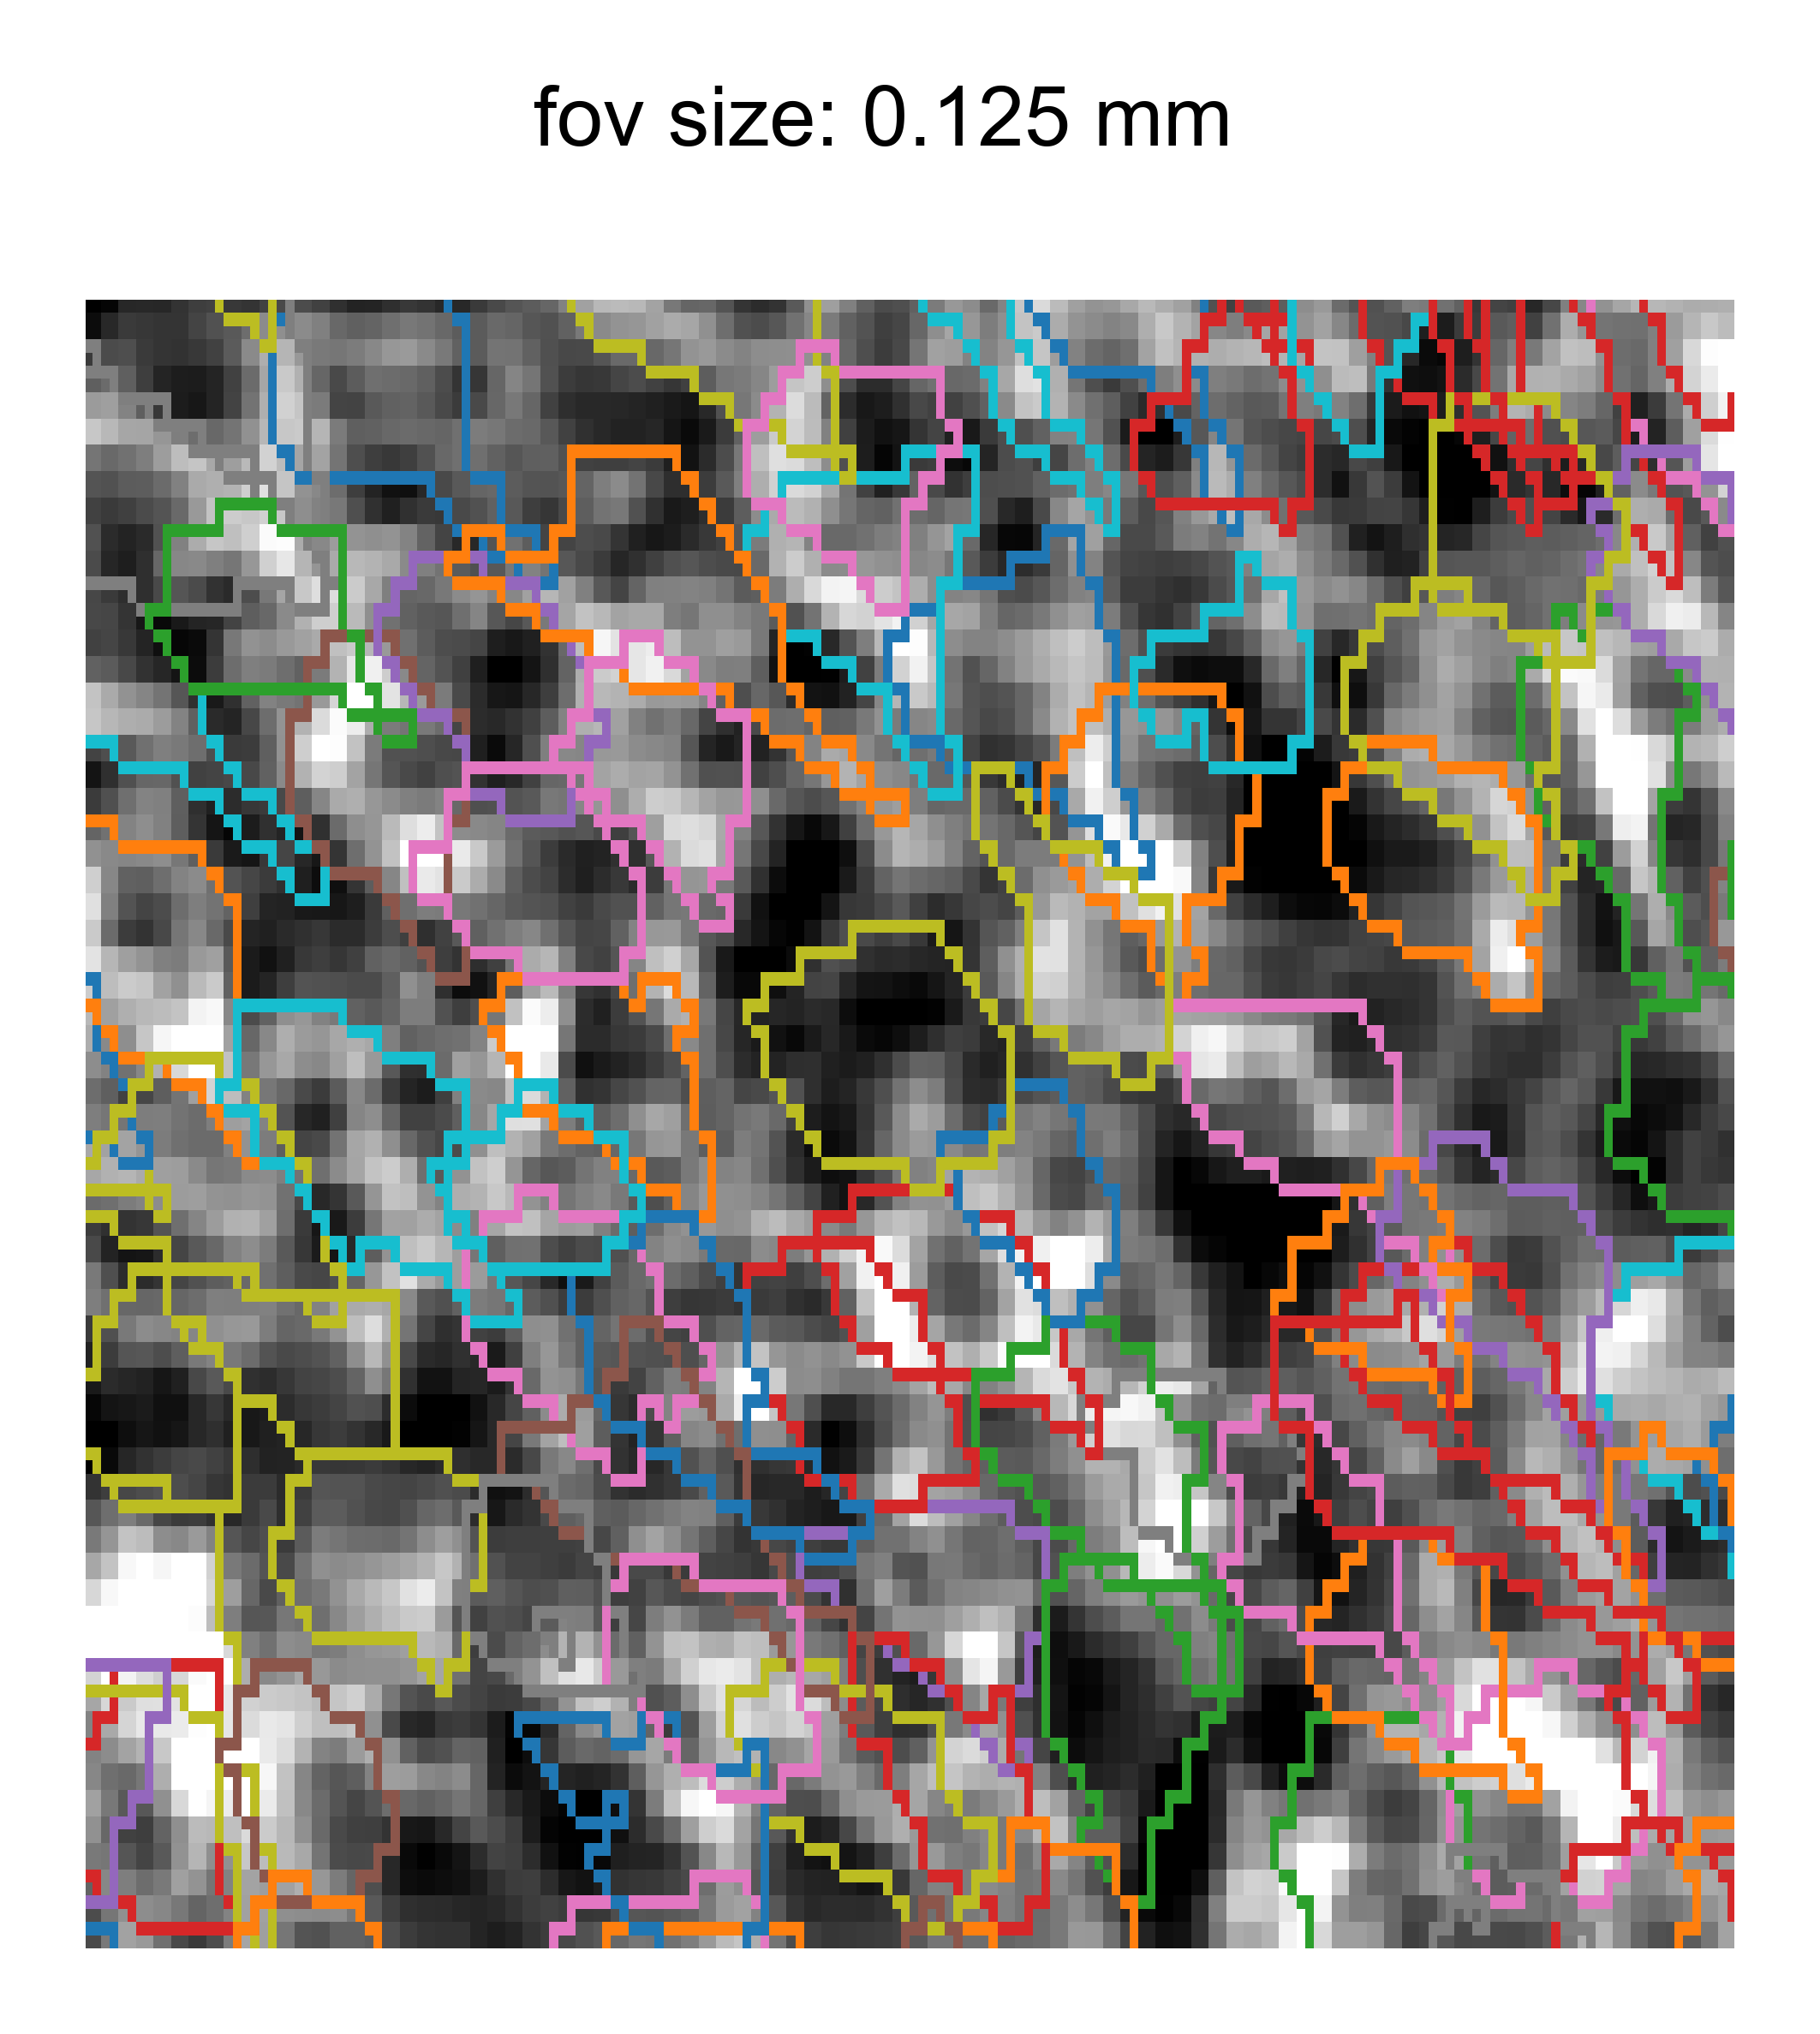

In [17]:
# crop settings
crop_img_type = 'enhanced_img' # 'mean_img', 'enhanced_img', 'max_img', 'lambda_weights'
show_contours=True
contours_rescale_factor=2 # controls mask line thickness (higher is thinnger) 
                            #NOTE!! the script runs faster if this number is low you can turn it up at the end
mask_alpha=1
disp_range_crop = [0.3,0.8]
crop_size_mm = 0.125
crop_origin_mm = [0.7,1.25] #left bottom [1.0,0.8]

#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=1000)
ax = fig.add_subplot(1, 1, 1)
#get image.
img = data.images.original[session_ind][crop_img_type]
img_8bit = skimage.exposure.rescale_intensity(img,in_range=tuple(disp_range_crop),out_range=(0,255)).astype(np.uint8)

# get image of cell masks.
roi_info = data.cells.multi_session.original[session_ind] if roi_type=='multi_session' else data.cells.single_session[session_ind]
if show_contours:
    cells_img = create_mask_img(roi_info, img.shape,contours=True,contour_upsampling=contours_rescale_factor)
else:
    cells_img = create_mask_img(roi_info, img.shape)

# create random colormap.
num_cells = cells_img.max()
np.random.seed(color_seed_num)
# fixed number of colors.
rand_cmap = np.array(sns.color_palette("tab10"))
rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]

# create roi masks.
img_8bit=skimage.transform.rescale(img_8bit, contours_rescale_factor,order=0)
mask_rgb = skimage.color.label2rgb(cells_img,img_8bit, colors=rand_cmap,alpha=mask_alpha,bg_color=None) # something labeled as '1' will look at the first (zero index] color in the list. create mask sets first mask as 0 in the image (so effectively skipped)
cell_colors = np.vstack((np.zeros((rand_cmap.shape[1])),rand_cmap)) # because first one is (zero) is background

ax.imshow(mask_rgb, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none')
ax.axis('off')
# crop region.
crop_mm = [[crop_origin_mm[0],crop_origin_mm[0]+ crop_size_mm],
           [crop_origin_mm[1],crop_origin_mm[1]+ crop_size_mm]] #xy
ax.set_xlim(crop_mm[0])
ax.set_ylim(crop_mm[1])
# Add crop region.
fig.suptitle(f'fov size: {crop_size_mm} mm')

# 4. Traces.

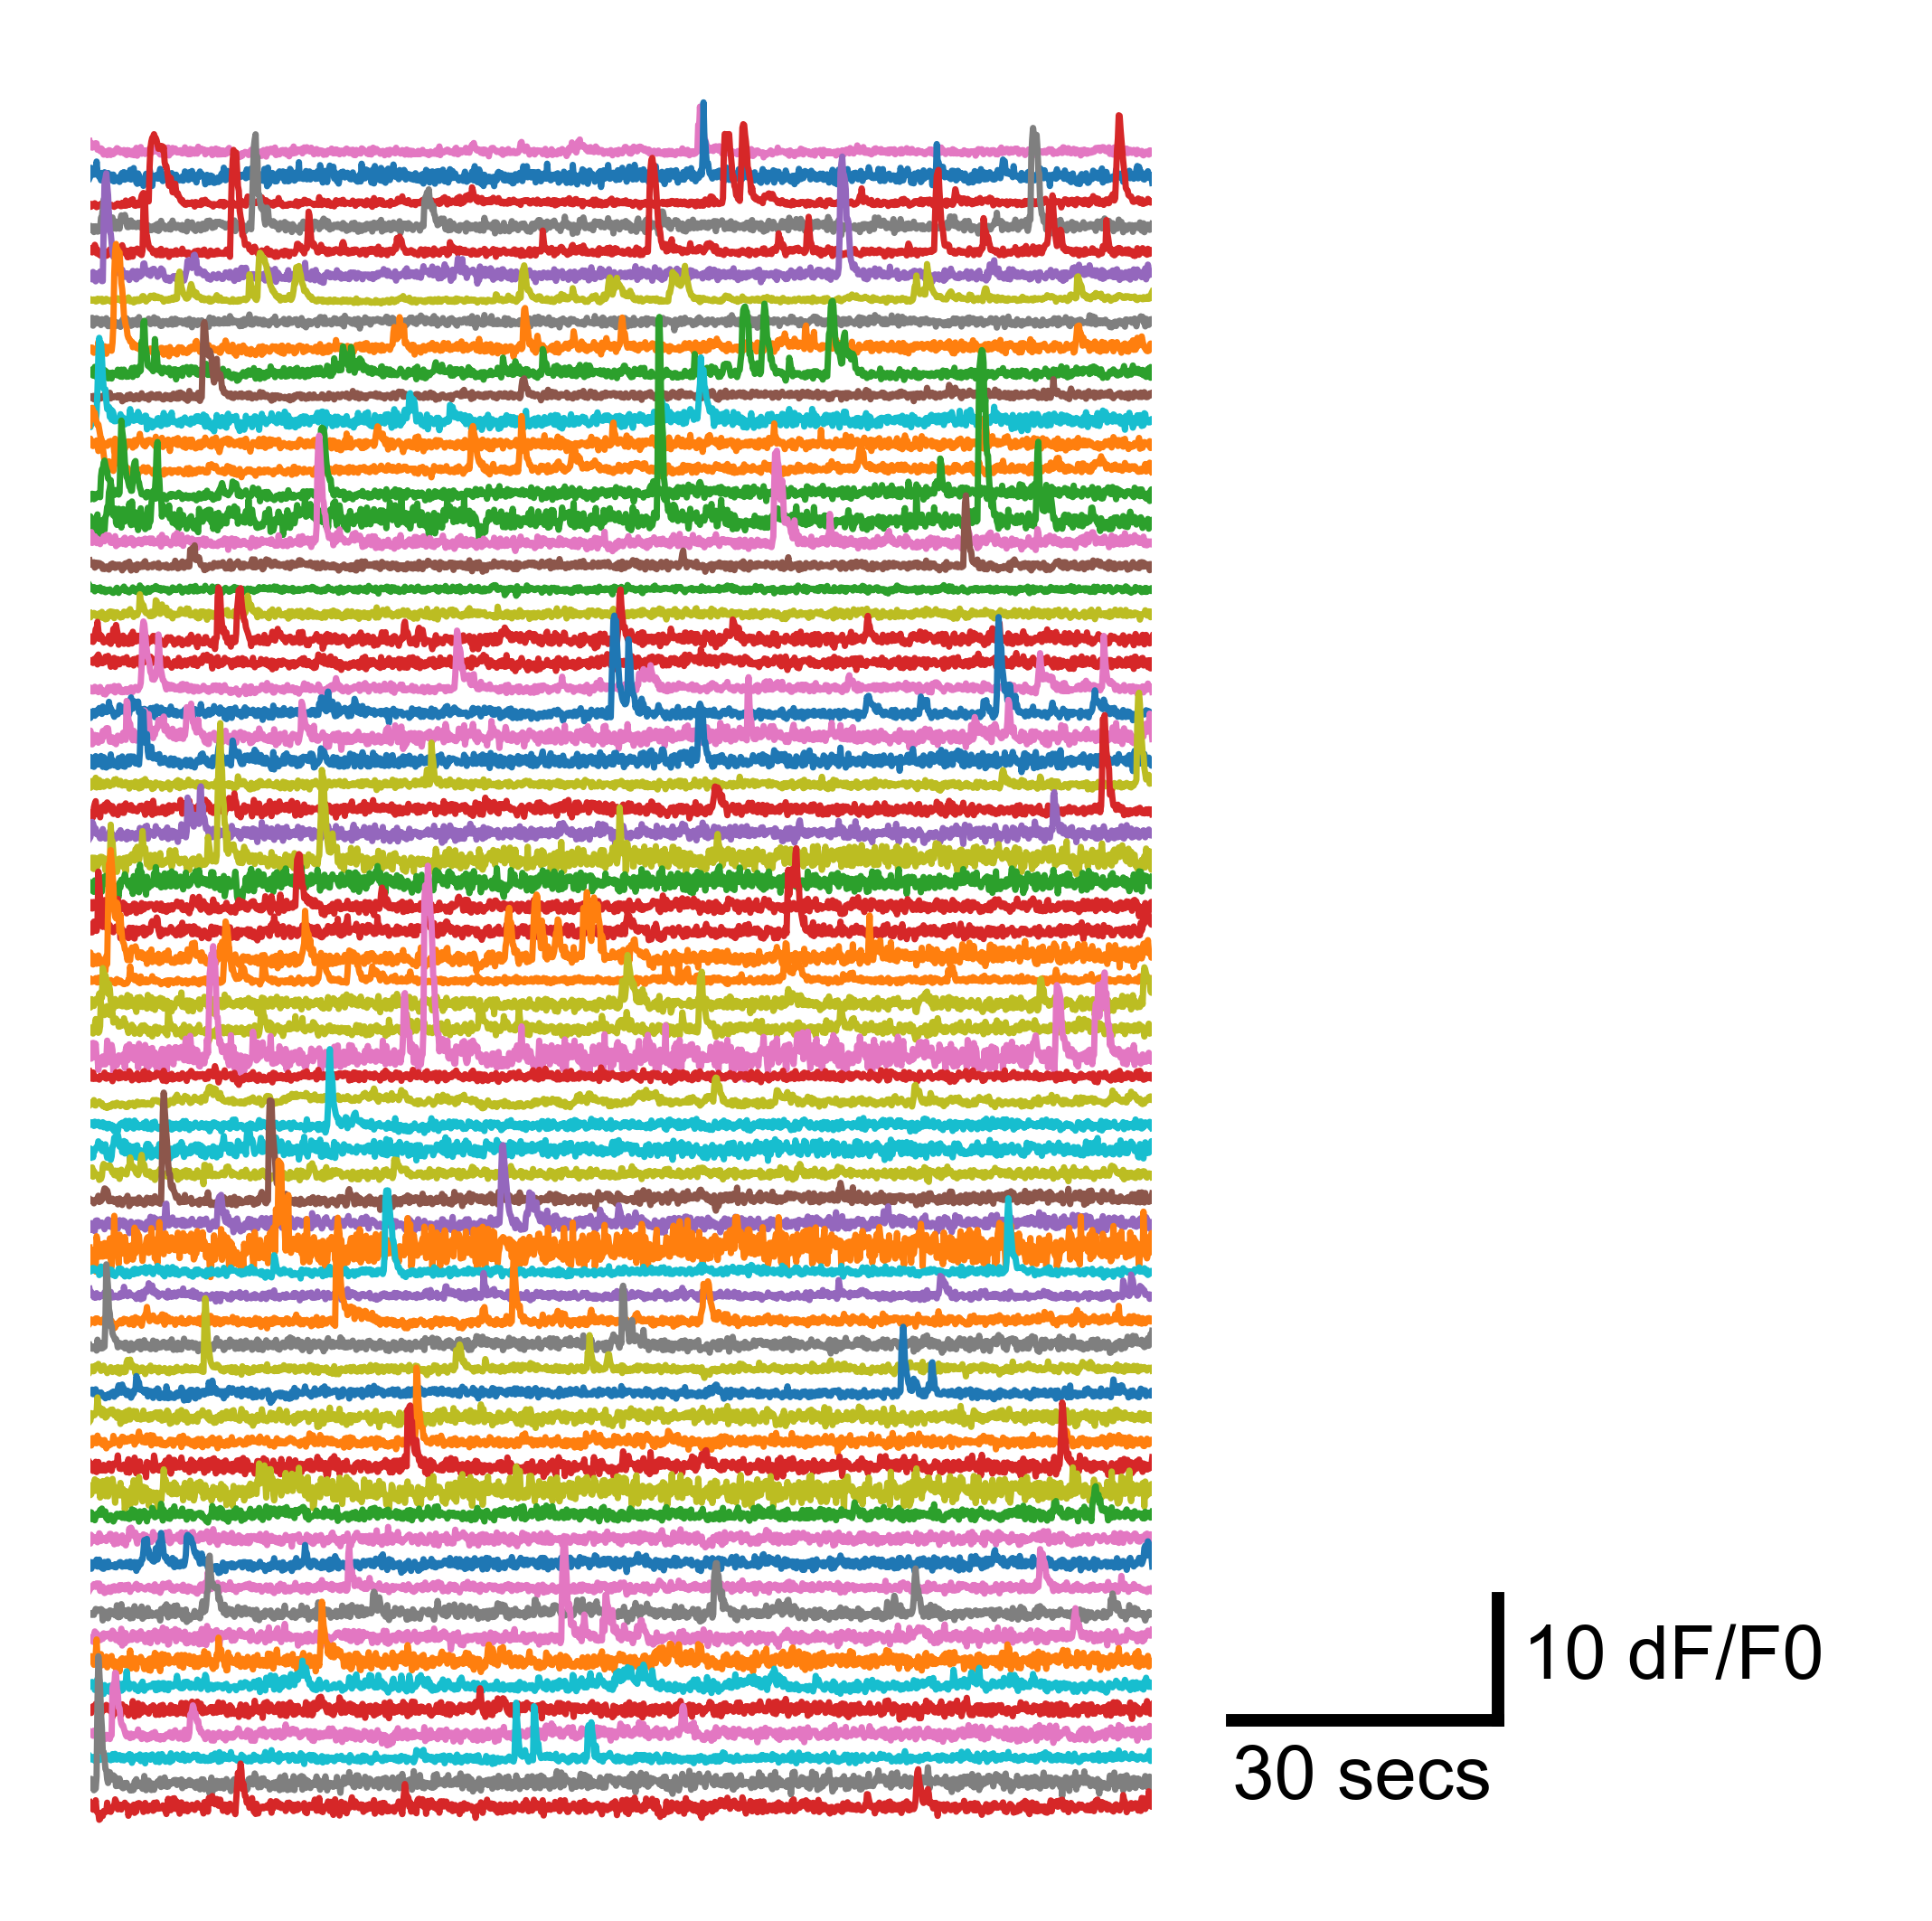

In [18]:
# traces.
frame_start_ind = 0 # rank of most active time window to show.
color_seed_num = 2 # for randomizing colors.
frame_duration_sec = 120 # duration of shown traces in seconds
trace_spacing = 2 # this is the spacing of each neuron trace in y (cosmetic)
time_scale_bar_size = 30 # seconds
df_scale_bar_size = 10 # df/F0
trace_line_width = 0.5 # in points.
max_y = 5 # max y limits for traces (top of the plot)
use_black_bg = False

axs = plt.figure(figsize=(2.5,2.5),dpi=1000).subplot_mosaic(
    [
        ["traces","legend"],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1],
    # set the width ratios between the columns
    width_ratios=[ 1,0.5],
)

# find cells in crop
# get centers of cells.
medians = np.array([cell['med']for cell in roi_info])
y = (medians[:,0]*pix_size[1])/1000
x = (medians[:,1]*pix_size[0])/1000
medians = np.vstack((x,y)).transpose()
crop_inds = np.argwhere((medians[:,0]>=crop_mm[0][0]) & (medians[:,0]<=crop_mm[0][1]) &
                  (medians[:,1]>=crop_mm[1][0]) & (medians[:,1]<=crop_mm[1][1])).flatten()
crop_colors = cell_colors[crop_inds]
ax = axs['traces']

# Can now use crop_cells and crop colors to display traces.
cells_act = data.signals.multi_session.Fns if roi_type=='multi_session' else data.signals.single_session.Fns
cells_act = cells_act[session_ind][crop_inds,:] # dim 0: selected cells, dim1: activity
cells_act = df_over_f0(cells_act,sigma_baseline=200, window_size=200)[0]

num_crop_cells = cells_act.shape[0]
num_frames = cells_act.shape[1]
frame_duration = 1/data.meta['imaging']['frame_rate']

# sort time windows with most activity.
act_win_info = sort_windows_by_max_act(cells_act,int(frame_duration_sec / frame_duration),frame_duration)
frame_start_time_sec = act_win_info.start_time.to_numpy()[frame_start_ind]

for ineuron in range(num_crop_cells):
    y = cells_act[ineuron,:]-(ineuron*trace_spacing)
    x = np.arange(0,num_frames*frame_duration,frame_duration)
    ax.plot(x,y,color = crop_colors[ineuron,:],marker='',linewidth=trace_line_width)
ax.set_xlim(frame_start_time_sec ,frame_start_time_sec + frame_duration_sec)
ax.set_ylim(-((ineuron+1)*trace_spacing),max_y)
if use_black_bg:
    ax.set_facecolor(ax_bg_color)
    ax.set_xticks([])
    ax.set_yticks([])
else:
    ax.set_axis_off()
##
# draw legend.
##

# Create scale bar
scale_bar = AnchoredDoubleScaleBar(ax.transData, time_scale_bar_size, 'secs',df_scale_bar_size,'dF/F0')
ax = axs['legend']
ax.add_artist(scale_bar)
ax.set_axis_off()

# Appendix.

# Show overview one slice

change so that it uses proper extent and setting axis limits (gets confusing with upsampled masks)

(0.0, 1.0, 0.0, 1.0)

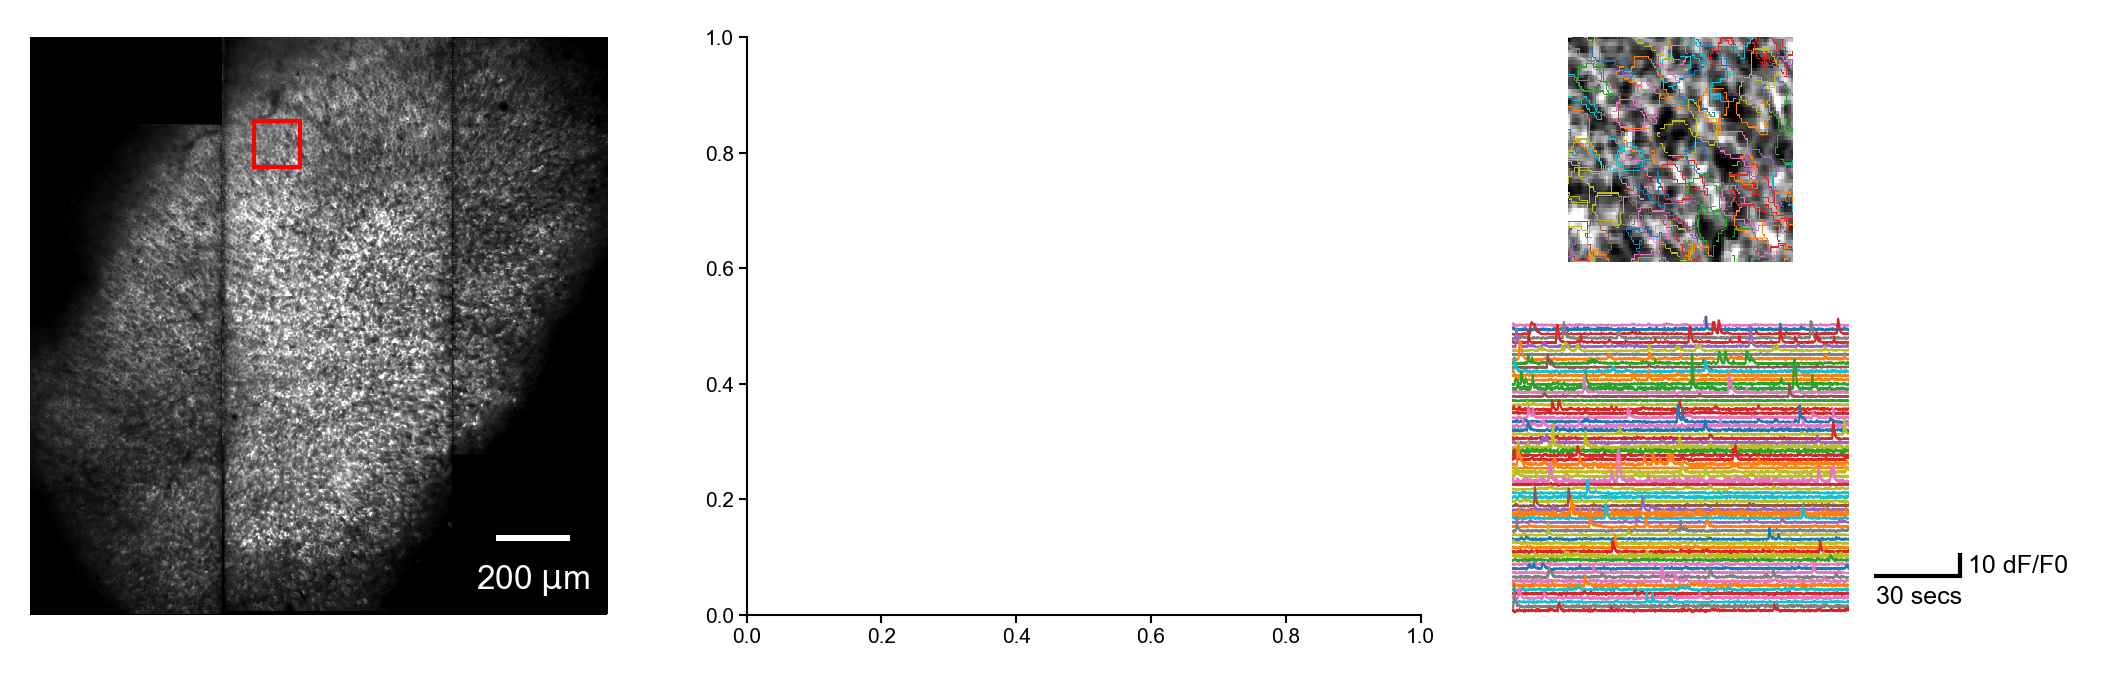

In [ ]:
# images to access.
session_ind = 0 
img_type = 'mean_img'
animal = 'A7' 
roi_type = 'single_session' # single_session or multi_session cell roi's

# FOV settings
disp_range = [100,1800]
pix_size = [1.333,2] #xy
fov_mm = [[0.1,1.65],[0.05,1.6]] # fov crop in x -y
show_axis=False

# crop
crop_img_type = 'enhanced_img' # 'mean_img', 'enhanced_img', 'max_img', 'lambda_weights'
show_contours=True
contours_rescale_factor=3 # controls mask line thickness (higher is thinnger) 
                            #NOTE!! the script runs faster if this number is low you can turn it up at the end
mask_alpha=1
disp_range_crop = [0.3,0.8]
crop_size_mm = 0.125
crop_origin_mm = [0.7,1.25] #left bottom [1.0,0.8]

# traces.
frame_start_ind = 0 # rank of most active time window to show.
color_seed_num = 2 # for randomizing colors.
frame_duration_sec = 120 # duration of shown traces in seconds
trace_spacing = 2 # this is the spacing of each neuron trace in y (cosmetic)
time_scale_bar_size = 30 # seconds
df_scale_bar_size = 10 # df/F0
trace_line_width = 0.5 # in points.
max_y = 5 # max y limits for traces (top of the plot)
use_black_bg = False

assert (roi_type=='single_session') | (roi_type == 'multi_session')
# Grab data.
data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')

#plot
axs = plt.figure(figsize=(9,2.5),dpi=300).subplot_mosaic(
    [
         ["fov", "fov_mask","crop","legend"],
        ["fov", "fov_mask","traces","legend"],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[0.75,1],
    # set the width ratios between the columns
    width_ratios=[1, 1, 0.5,0.2],
)

##
# Full FOV
##
ax=axs['fov']
ax.set_facecolor("black")
# get images.
img = data.images.original[session_ind][img_type]

ax.imshow(img, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none',cmap='gray', vmin=disp_range[0], vmax=disp_range[1]) # correct non uniform aspect ratio.
ax.set_xlim(fov_mm[0])
ax.set_ylim(fov_mm[1])
# Create scale bar
scalebar = ScaleBar(1, "mm", length_fraction=0.25,location='lower right',frameon=False,color='white',pad=0.5,
                   font_properties={'family':'Arial','size':8})
ax.add_artist(scalebar)

# Ad crop region.
ax.add_patch(Rectangle((crop_mm[0][0],crop_mm[1][0]),
                       crop_mm[0][1]-crop_mm[0][0], 
                       crop_mm[1][1]-crop_mm[1][0],
                      facecolor='none', edgecolor='red',linewidth=1,))

# format
if not show_axis:
    ax.tick_params(left = False, bottom=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
##
# Crop region with contours
##
crop_mm = [[crop_origin_mm[0],crop_origin_mm[0]+ crop_size_mm],
           [crop_origin_mm[1],crop_origin_mm[1]+ crop_size_mm]] #xy
ax = axs['crop']
img = data.images.original[session_ind][crop_img_type]
img_8bit = skimage.exposure.rescale_intensity(img,in_range=tuple(disp_range_crop),out_range=(0,255)).astype(np.uint8)

# get image of cell masks.
roi_info = data.cells.multi_session.original[session_ind] if roi_type=='multi_session' else data.cells.single_session[session_ind]
if show_contours:
    cells_img = create_mask_img(roi_info, img.shape,contours=True,contour_upsampling=contours_rescale_factor)
else:
    cells_img = create_mask_img(roi_info, img.shape)

# create random colormap.
num_cells = cells_img.max()
np.random.seed(color_seed_num)
# fixed number of colors.
rand_cmap = np.array(sns.color_palette("tab10"))
rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]

# create roi masks.
if show_contours: img_8bit=skimage.transform.rescale(img_8bit, contours_rescale_factor,order=0)
mask_rgb = skimage.color.label2rgb(cells_img,img_8bit, colors=rand_cmap,alpha=mask_alpha,bg_color=None) # something labeled as '1' will look at the first (zero index] color in the list. create mask sets first mask as 0 in the image (so effectively skipped)
cell_colors = np.vstack((np.zeros((rand_cmap.shape[1])),rand_cmap)) # because first one is (zero) is background

ax.imshow(mask_rgb, origin='lower',extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000], interpolation='none')
ax.axis('off')
ax.set_xlim(crop_mm[0])
ax.set_ylim(crop_mm[1])

# Create scale bar
#scalebar = ScaleBar(1, "mm", length_fraction=0.25,location='lower right',
#                    frameon=True,box_color='black',color='white',pad=0.5,box_alpha=0.5,
#                   font_properties={'family':'Arial','size':8})
#ax.add_artist(scalebar)

##
# ROI traces
##

# find cells in crop
# get centers of cells.
medians = np.array([cell['med']for cell in roi_info])
y = (medians[:,0]*pix_size[1])/1000
x = (medians[:,1]*pix_size[0])/1000
medians = np.vstack((x,y)).transpose()
crop_inds = np.argwhere((medians[:,0]>=crop_mm[0][0]) & (medians[:,0]<=crop_mm[0][1]) &
                  (medians[:,1]>=crop_mm[1][0]) & (medians[:,1]<=crop_mm[1][1])).flatten()
crop_colors = cell_colors[crop_inds]
ax = axs['traces']

# Can now use crop_cells and crop colors to display traces.
cells_act = data.signals.multi_session.Fns if roi_type=='multi_session' else data.signals.single_session.Fns
cells_act = cells_act[session_ind][crop_inds,:] # dim 0: selected cells, dim1: activity
cells_act = df_over_f0(cells_act,sigma_baseline=200, window_size=200)[0]

num_crop_cells = cells_act.shape[0]
num_frames = cells_act.shape[1]
frame_duration = 1/data.meta['imaging']['frame_rate']

# sort time windows with most activity.
act_win_info = sort_windows_by_max_act(cells_act,int(frame_duration_sec / frame_duration),frame_duration)
frame_start_time_sec = act_win_info.start_time.to_numpy()[frame_start_ind]

for ineuron in range(num_crop_cells):
    y = cells_act[ineuron,:]-(ineuron*trace_spacing)
    x = np.arange(0,num_frames*frame_duration,frame_duration)
    ax.plot(x,y,color = crop_colors[ineuron,:],marker='',linewidth=trace_line_width)
ax.set_xlim(frame_start_time_sec ,frame_start_time_sec + frame_duration_sec)
ax.set_ylim(-((ineuron+1)*trace_spacing),max_y)
if use_black_bg:
    ax.set_facecolor(ax_bg_color)
    ax.set_xticks([])
    ax.set_yticks([])
else:
    ax.set_axis_off()
##
# draw legend.
##

# Create scale bar
scale_bar = AnchoredDoubleScaleBar(ax.transData, time_scale_bar_size, 'secs',df_scale_bar_size,'dF/F0')
ax = axs['legend']
ax.add_artist(scale_bar)
ax.axis('off')

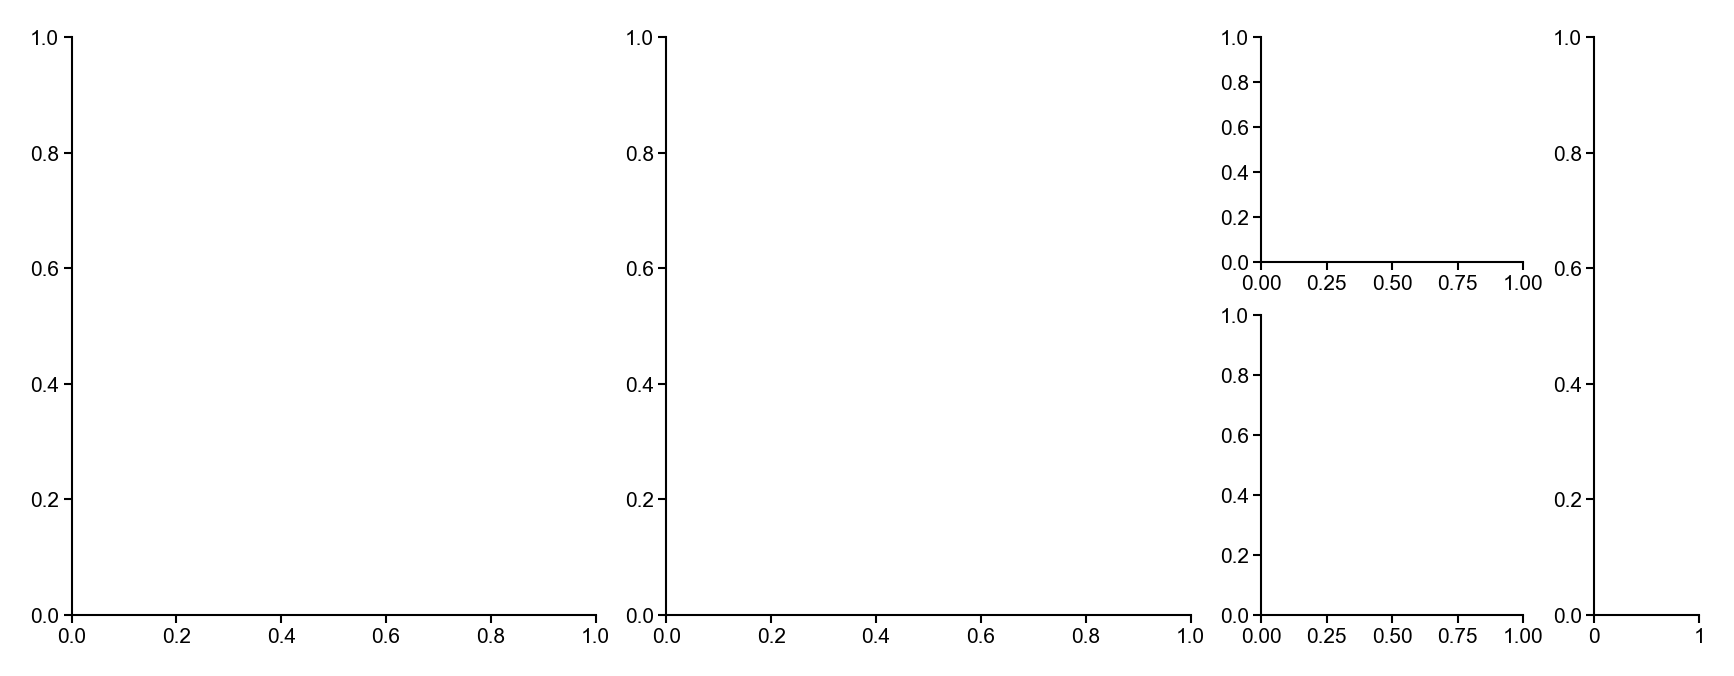

In [ ]:
# plot
axs = plt.figure(figsize=(7,2.5),dpi=300).subplot_mosaic(
    [
         ["fov", "fov_mask","crop","legend"],
        ["fov", "fov_mask","traces","legend"],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[0.75,1],
    # set the width ratios between the columns
    width_ratios=[1, 1, 0.5,0.2],
)


In [ ]:
a = data.images.original[0]
print(a.keys())

dict_keys(['mean_img', 'enhanced_img', 'max_img', 'lambda_weights'])


In [ ]:
import seaborn as sns

sns.color_palette("husl", 15)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9542900080364486, 0.4779505175890752, 0.1963917622115608),
 (0.7930046244373694, 0.5708100522446624, 0.19489531984381053),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.5571803870240879, 0.6507747739933957, 0.19331667588333168),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.20774052347943134, 0.6813852191365138, 0.6002900398972028),
 (0.21316806282417172, 0.6731234926210208, 0.6838056741516414),
 (0.21979956608283252, 0.6625157876850336, 0.7732093159317208),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5830408541921136, 0.5695319215803094, 0.9583591966369759),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.959647907830888, 0.3748291312853892, 0.893004453766301),
 (0.9642903119819891, 0.41420146582831974, 0.7188681186026104)]

In [ ]:
## Debug
#ax.imshow(img, origin='lower', extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000],
#          interpolation='none',cmap='gray', vmin=disp_range_crop[0], vmax=disp_range_crop[1]) # correct non uniform aspect ratio.
#ax.set_xlim(crop_mm[0])
#ax.set_ylim(crop_mm[1])
#ax.scatter(medians[crop_inds,0],medians[crop_inds,1],color=cell_colors[crop_inds])